# IMPORT LIBRARY

In [1]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow.keras.applications')

# IMPORT DATASET

In [5]:
dir = 'D:/1. KULIAH/SEM9/SKRIPSI/CABAI/CODE/FINAL-CODE/dataset/'

In [6]:
train_dir = os.path.join(dir, 'toSplit/train/')
val_dir = os.path.join(dir, 'toSplit/val/')
test_dir = os.path.join(dir, 'toSplit/test/')

# DATA UNDERSTANDING

In [7]:
# List kelas (subfolder) dalam setiap direktori
classes = os.listdir(train_dir)

# Inisialisasi variabel untuk menyimpan nilai maksimum dan minimum
format_data = ''
max_size_data = (0, 0)
min_size_data = (float('inf'), float('inf'))
channels = 0

for class_name in classes:
    class_dir_train = os.path.join(train_dir, class_name)
    class_dir_val = os.path.join(val_dir, class_name)
    class_dir_test = os.path.join(test_dir, class_name)

    # Menghitung dan menampilkan informasi tentang setiap gambar
    for folder in [class_dir_train, class_dir_val, class_dir_test]:
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            format_data = img.format
            size_data = img.size
            channels = len(img.getbands())

            if size_data > max_size_data:
                max_size_data = size_data
            if size_data < min_size_data:
                min_size_data = size_data

# Menampilkan nilai maksimum dan minimum
print(f'Format Data: {format_data}')
print(f'Max Ukuran Data: {max_size_data}')
print(f'Min Ukuran Data: {min_size_data}')
print(f'Ukuran Channel: {channels}')

Format Data: JPEG
Max Ukuran Data: (640, 640)
Min Ukuran Data: (256, 256)
Ukuran Channel: 3


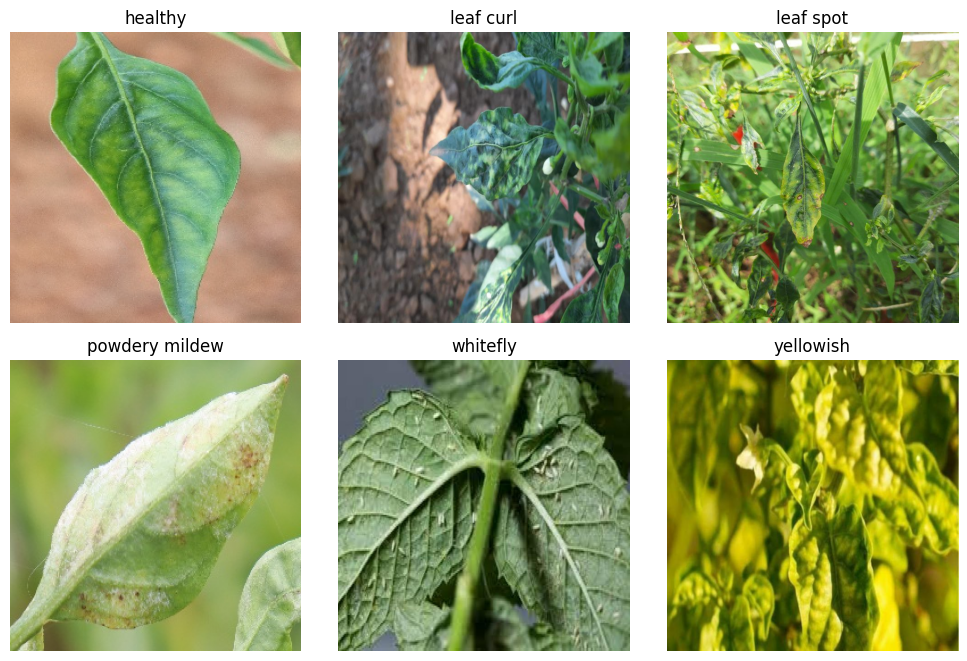

In [8]:
# Mendapatkan daftar kelas (folder) di dalam direktori training
classes = os.listdir(train_dir)

plt.figure(figsize=(10,10))

# Looping untuk setiap kelas
for i, cls in enumerate(classes):
    # Mengambil semua gambar dalam folder kelas tersebut
    images = os.listdir(os.path.join(train_dir, cls))
    
    # Memilih satu gambar secara acak
    img_name = random.choice(images)
    
    # Membaca dan menampilkan gambar
    img_path = os.path.join(train_dir, cls, img_name)
    img = mpimg.imread(img_path)
    
    # Menampilkan gambar dengan subplot
    fig = plt.subplot(3,3,i+1)
    fig.imshow(img)
    fig.set_title(cls)  # Menambahkan judul sesuai nama kelas
    fig.axis('off')

plt.tight_layout()
plt.show()

# DATA PREPARATION

In [9]:
IMG_SIZE = 224

In [10]:
train_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1.0/255.0)

In [11]:
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical',
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical',
    shuffle=True
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical',
    shuffle=False
)

Found 894 images belonging to 6 classes.
Found 257 images belonging to 6 classes.
Found 132 images belonging to 6 classes.


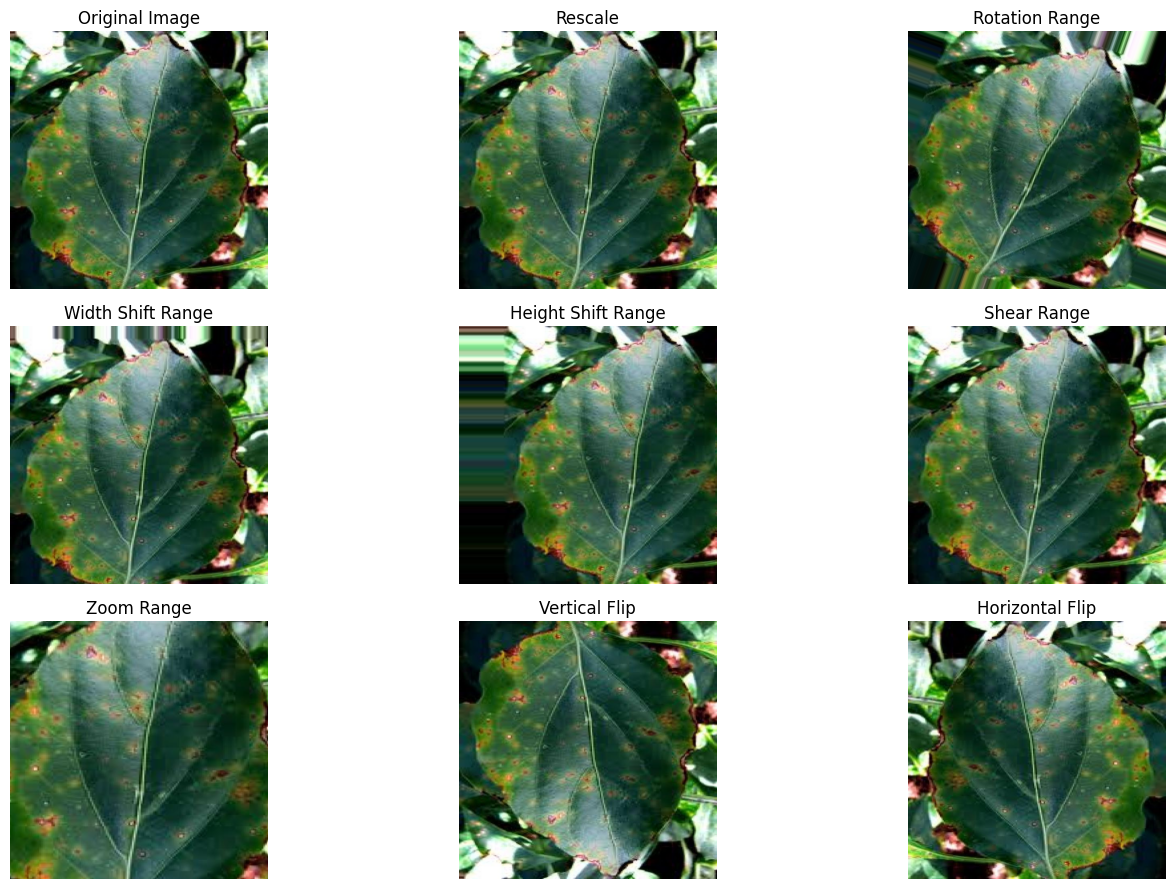

In [12]:
# Fungsi untuk menampilkan gambar dengan keterangan augmentasi
def display_augmented_images(generator, title, ax, img):
    gen = generator.flow(img, batch_size=1)
    augmented_img = next(gen)[0]  # Ambil satu gambar yang diaugmentasi
    ax.imshow(augmented_img)
    ax.set_title(title)
    ax.axis('off')

# Muat satu gambar (ganti path gambar Anda)
img_file = 'leaf spot/bercak_daun-32-_jpg.rf.733e7c67ed57e3848f755dafb78300f1.jpg'

# Gabungkan train_dir dengan img_file untuk menghasilkan path lengkap
img_path = os.path.join(train_dir, img_file)

# Muat gambar asli
original_img = plt.imread(img_path)
img = np.expand_dims(original_img, axis=0)  # Tambahkan dimensi untuk batch

# Fungsi untuk menampilkan gambar dengan keterangan augmentasi
def display_augmented_images(generator, title, ax, img):
    gen = generator.flow(img, batch_size=1)
    augmented_img = next(gen)[0]  # Ambil satu gambar yang diaugmentasi
    ax.imshow(augmented_img)
    ax.set_title(title)
    ax.axis('off')

# Inisialisasi berbagai ImageDataGenerator dengan augmentasi spesifik
generators = [
    (ImageDataGenerator(rescale=1.0/255.0), 'Rescale'),
    (ImageDataGenerator(rotation_range=30, rescale=1.0/255.0), 'Rotation Range'),
    (ImageDataGenerator(width_shift_range=0.2, rescale=1.0/255.0), 'Width Shift Range'),
    (ImageDataGenerator(height_shift_range=0.2, rescale=1.0/255.0), 'Height Shift Range'),
    (ImageDataGenerator(shear_range=0.2, rescale=1.0/255.0), 'Shear Range'),
    (ImageDataGenerator(zoom_range=0.3, rescale=1.0/255.0), 'Zoom Range'),
    (ImageDataGenerator(vertical_flip=True, rescale=1.0/255.0), 'Vertical Flip'),
    (ImageDataGenerator(horizontal_flip=True, rescale=1.0/255.0), 'Horizontal Flip')
]


# Pastikan kita tidak lebih dari jumlah subplot yang ada
num_generators = len(generators)

# Plot gambar asli dan augmentasi dalam grid
fig, ax = plt.subplots(3, 3, figsize=(15,9))

# Tampilkan gambar asli di subplot pertama
ax[0, 0].imshow(original_img)
ax[0, 0].set_title("Original Image")
ax[0, 0].axis('off')

# Tampilkan gambar hasil augmentasi
for i, (gen, title) in enumerate(generators):
    if i < 8:  # Hanya ada 8 generator, jadi kita gunakan ini
        row = (i + 1) // 3  # Menghitung baris dengan 3 kolom
        col = (i + 1) % 3   # Menghitung kolom
        display_augmented_images(gen, title, ax[row, col], img)

plt.tight_layout()
plt.show()

In [13]:
len(train_dir)

70

In [14]:
len(val_dir)

68

In [15]:
len(test_dir)

69

# MODELING

In [16]:
base_model = MobileNet(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [17]:
# Membekukan layer dasar MobileNet agar tidak dilatih ulang
base_model.trainable = False

In [18]:
# Menambahkan lapisan-lapisan tambahan di atas MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256 , activation='relu')(x)
x = Dropout(0.5)(x)  # Menambahkan Dropout dengan 50% dari neuron dimatikan
predictions = Dense(train_data.num_classes, activation='softmax')(x)

In [19]:
# Membangun model
model = Model(inputs=base_model.input, outputs=predictions)

In [20]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
)

Epoch 1/30


c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


28/28 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.2920 - loss: 2.0991 - val_accuracy: 0.6887 - val_loss: 0.9177
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5880 - loss: 1.0870 - val_accuracy: 0.6732 - val_loss: 0.8957
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6860 - loss: 0.8624 - val_accuracy: 0.7315 - val_loss: 0.7506
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6939 - loss: 0.8124 - val_accuracy: 0.7977 - val_loss: 0.6348
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7166 - loss: 0.7157 - val_accuracy: 0.7626 - val_loss: 0.6558
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7140 - loss: 0.7360 - val_accuracy: 0.8016 - val_loss: 0.6333
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7607 - loss: 0.6046 - val_accuracy: 0.7899 - val_loss: 0.5898
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7672 - loss: 0.6196 - val_accuracy: 0.8093 - val_loss: 0.5744
Epo

# EVALUASI

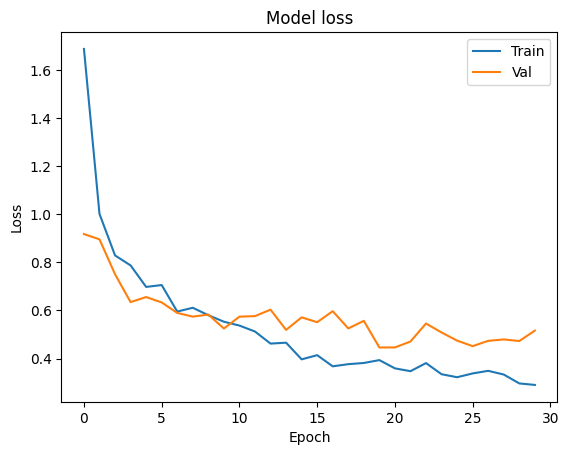

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

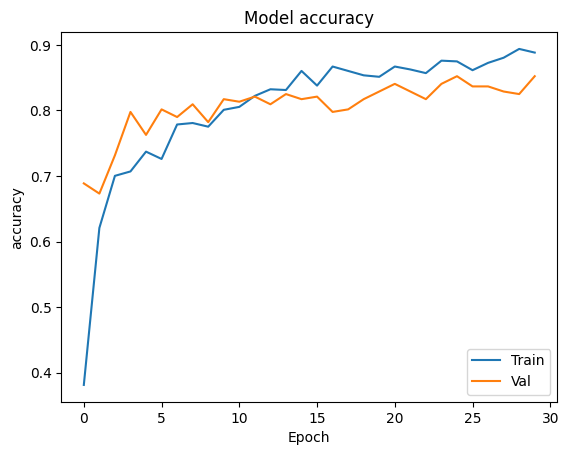

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [24]:
# Prediksi pada data uji
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step


In [25]:
# Mendapatkan label sebenarnya
y_true = test_data.classes

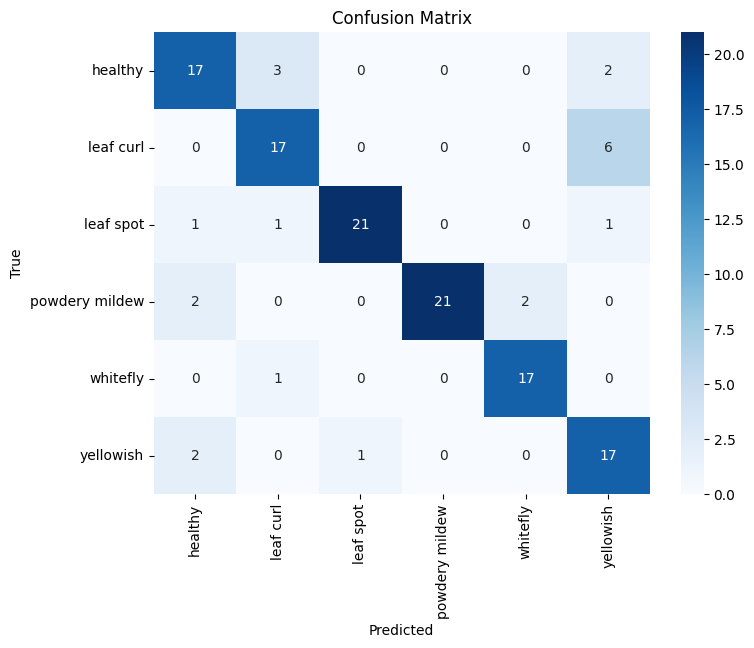

In [26]:
# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Menampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.class_indices.keys(),
            yticklabels=train_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
# Dictionary atau daftar label kelas sesuai dengan confusion matrix
class_labels = {0: "healthy", 1: "leaf curl", 2: "leaf spot", 
                3: "powdery mildew", 4: "whitefly", 5: "yellowish"}

# Ubah dictionary menjadi daftar nama label sesuai urutan indeks
target_names = [class_labels[i] for i in range(len(class_labels))]

# Tampilkan laporan klasifikasi dengan label sebenarnya
print(classification_report(y_true, y_pred_classes, target_names=target_names))

                precision    recall  f1-score   support

       healthy       0.77      0.77      0.77        22
     leaf curl       0.77      0.74      0.76        23
     leaf spot       0.95      0.88      0.91        24
powdery mildew       1.00      0.84      0.91        25
      whitefly       0.89      0.94      0.92        18
     yellowish       0.65      0.85      0.74        20

      accuracy                           0.83       132
     macro avg       0.84      0.84      0.84       132
  weighted avg       0.85      0.83      0.84       132



In [28]:
# Mencetak hasil training dan validation terakhir
train_loss, train_accuracy = model.evaluate(train_data)
val_loss, val_accuracy = model.evaluate(val_data)
test_loss, test_accuracy = model.evaluate(test_data)

28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 851ms/step - accuracy: 0.9348 - loss: 0.1820
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 545ms/step - accuracy: 0.8458 - loss: 0.4819
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - accuracy: 0.7973 - loss: 0.7553


In [29]:
print(f"Training Loss: {train_loss}")
print(f"Val Loss: {val_loss}")
print(f"Test Loss: {test_loss}")
print()
print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Val Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Training Loss: 0.183036208152771
Val Loss: 0.4615979790687561
Test Loss: 0.6362992525100708

Training Accuracy: 93.40%
Val Accuracy: 84.82%
Test Accuracy: 83.33%


# SAVE MODEL

In [30]:
model.save(dir+"hasil/model-30ep.h5")